# Import necassary libraries

In [1]:
import numpy as np
import pandas as pd
import os
import torch
import wandb
import ast
import re
from sklearn.model_selection import train_test_split
from simpletransformers.classification import ClassificationModel
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
torch.cuda.is_available()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# Retrieve dataset and prepare it for the model

Index(['Unnamed: 0', 'names', 'contents', 'classIndex'], dtype='object')
Index(['contents', 'classIndex'], dtype='object')
[0 1]


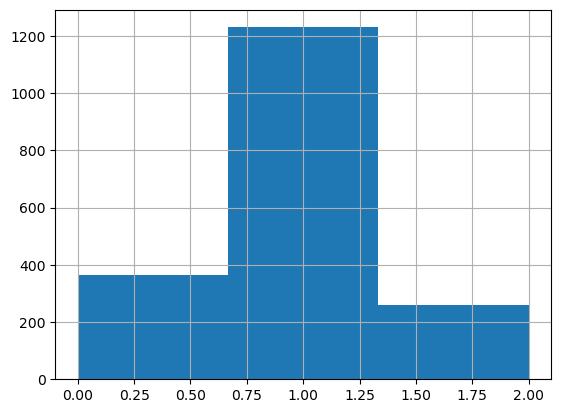

In [2]:
classesList = ['andere','factuur','aanmaning']

Dataset = pd.read_csv(os.getcwd() + "\\test_extraction_emails.csv")
Dataset['classIndex'].hist(bins=3)
print(Dataset.columns)
Dataset = Dataset.drop(['Unnamed: 0','names'],axis=1)
print(Dataset.columns)

def reducedDataset(dataset):
    dataset = dataset.drop(dataset[dataset['classIndex'] == 0].index,axis=0)
    dataset.loc[dataset['classIndex'] == 1, 'classIndex'] = 0
    dataset.loc[dataset['classIndex'] == 2, 'classIndex'] = 1
    return dataset

Dataset = reducedDataset(Dataset)

print(Dataset['classIndex'].unique())

### Split dataset into train/test set

In [3]:
trainSet, testSet = train_test_split(Dataset, test_size=0.1, stratify=Dataset['classIndex'], random_state=42)

### Define helper functions and variables

In [4]:
#check if CUDA capable gpu is available
cudaAvailable = torch.cuda.is_available()

def calculate_class_weights(trainingDataset):
    weightList = []
    numberOfLabels = len(trainingDataset['classIndex'].unique())
    for i in range(0,numberOfLabels):
        weight = len(trainingDataset.index) / (numberOfLabels * len(trainingDataset[trainingDataset['classIndex'] == i].index))
        weightList.append(weight)
    print(weightList)
    return weightList

# Define model/sweep and start training

In [9]:
sweepConfig = {'method' : 'grid', 'parameters' : {'num_train_epochs' : {'min' : 3, 'max' : 5}, 'learning_rate' : {'values' : [4e-5,5e-5,6e-5]}, 'train_batch_size' : {'values' : [16,32]}}}
sweepID = wandb.sweep(sweepConfig, project='Test sweep')

def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')

def train():
    wandb.init()
    trainArgumentsSweep = {'reprocess_input_data' : True, 'use_multiprocessing' : True, 'overwrite_output_dir' : True, 'use_early_stopping' : True, 'early_stopping_consider_epochs' : True, 'optimizer' : 'AdamW', 'save_model_every_epoch' : False, 'wandb_project' : 'Test sweep'}
    classifierSweep = ClassificationModel("bert","GroNLP/bert-base-dutch-cased", num_labels=len(trainSet['classIndex'].unique()),args=trainArgumentsSweep, use_cuda=True, weight=calculate_class_weights(trainSet), sweep_config=wandb.config)
    classifierSweep.train_model(trainSet)
    result, model_outputs, wrong_predictions = classifierSweep.eval_model(testSet, f1=f1_multiclass, confusionMatrix=confusion_matrix)
    wandb.log({'mcc' : result['mcc'], 'f1' : result['f1'], 'confusion_matrix' : result['confusionMatrix']})
    wandb.join()
    
wandb.agent(sweepID, train)

Create sweep with ID: ubozjgk2
Sweep URL: https://wandb.ai/spacehack100/Test%20sweep/sweeps/ubozjgk2


wandb: Agent Starting Run: 8yeu4moh with config:
wandb: 	learning_rate: 4e-05
wandb: 	num_train_epochs: 3
wandb: 	train_batch_size: 16


[0.6052393857271906, 2.875536480686695]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1340 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/84 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Training loss,▇█▁▄▁
f1,▁
global_step,▁▃▅▆█
lr,█▆▅▃▁
mcc,▁
Training loss,0.00884
f1,0.92617
global_step,250
lr,0.0
mcc,0.74001


wandb: Agent Starting Run: xdr99ovr with config:
wandb: 	learning_rate: 4e-05
wandb: 	num_train_epochs: 3
wandb: 	train_batch_size: 32


[0.6052393857271906, 2.875536480686695]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1340 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/42 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Training loss,█▁
f1,▁
global_step,▁█
lr,█▁
mcc,▁
Training loss,0.01037
f1,0.92617
global_step,100
lr,1e-05
mcc,0.75659


wandb: Agent Starting Run: zc1k9gcb with config:
wandb: 	learning_rate: 4e-05
wandb: 	num_train_epochs: 4
wandb: 	train_batch_size: 16


[0.6052393857271906, 2.875536480686695]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1340 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/84 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Training loss,▅▂▃█▁▁
f1,▁
global_step,▁▂▄▅▇█
lr,█▇▅▄▂▁
mcc,▁
Training loss,0.00056
f1,0.9396
global_step,300
lr,0.0
mcc,0.78733


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5w98rgf9 with config:
wandb: 	learning_rate: 4e-05
wandb: 	num_train_epochs: 4
wandb: 	train_batch_size: 32


[0.6052393857271906, 2.875536480686695]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1340 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/42 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Training loss,█▄▁
f1,▁
global_step,▁▅█
lr,█▄▁
mcc,▁
Training loss,0.00239
f1,0.94631
global_step,150
lr,0.0
mcc,0.80557


wandb: Agent Starting Run: e0csvlnq with config:
wandb: 	learning_rate: 4e-05
wandb: 	num_train_epochs: 5
wandb: 	train_batch_size: 16


[0.6052393857271906, 2.875536480686695]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1340 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/84 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Training loss,█▃█▁▁▁▁▁
f1,▁
global_step,▁▂▃▄▅▆▇█
lr,█▇▆▅▄▃▂▁
mcc,▁
Training loss,0.00022
f1,0.9396
global_step,400
lr,0.0
mcc,0.78244


wandb: Agent Starting Run: 0cjt8hyo with config:
wandb: 	learning_rate: 4e-05
wandb: 	num_train_epochs: 5
wandb: 	train_batch_size: 32


[0.6052393857271906, 2.875536480686695]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1340 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/42 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Training loss,▆▁▂█
f1,▁
global_step,▁▃▆█
lr,█▆▃▁
mcc,▁
Training loss,0.32844
f1,0.9396
global_step,200
lr,0.0
mcc,0.78244


wandb: Agent Starting Run: 6pbc0up4 with config:
wandb: 	learning_rate: 5e-05
wandb: 	num_train_epochs: 3
wandb: 	train_batch_size: 16


[0.6052393857271906, 2.875536480686695]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1340 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/84 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Training loss,█▅▃▁▁
f1,▁
global_step,▁▃▅▆█
lr,█▆▄▃▁
mcc,▁
Training loss,0.00166
f1,0.92617
global_step,250
lr,0.0
mcc,0.7335


wandb: Agent Starting Run: 7d3afrkt with config:
wandb: 	learning_rate: 5e-05
wandb: 	num_train_epochs: 3
wandb: 	train_batch_size: 32


[0.6052393857271906, 2.875536480686695]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1340 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/42 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Training loss,█▁
f1,▁
global_step,▁█
lr,█▁
mcc,▁
Training loss,0.05132
f1,0.92617
global_step,100
lr,1e-05
mcc,0.74777


wandb: Agent Starting Run: gj0zrurw with config:
wandb: 	learning_rate: 5e-05
wandb: 	num_train_epochs: 4
wandb: 	train_batch_size: 16


[0.6052393857271906, 2.875536480686695]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1340 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/84 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Training loss,█▁▂▁▂▁
f1,▁
global_step,▁▂▄▅▇█
lr,█▇▅▄▂▁
mcc,▁
Training loss,0.00117
f1,0.93289
global_step,300
lr,1e-05
mcc,0.75267


wandb: Agent Starting Run: pyve8t1o with config:
wandb: 	learning_rate: 5e-05
wandb: 	num_train_epochs: 4
wandb: 	train_batch_size: 32


[0.6052393857271906, 2.875536480686695]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1340 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/42 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Training loss,▄█▁
f1,▁
global_step,▁▅█
lr,█▄▁
mcc,▁
Training loss,0.00229
f1,0.91275
global_step,150
lr,1e-05
mcc,0.69268


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zv3yxrhw with config:
wandb: 	learning_rate: 5e-05
wandb: 	num_train_epochs: 5
wandb: 	train_batch_size: 16


[0.6052393857271906, 2.875536480686695]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1340 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/84 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Training loss,█▂▃▁▁▆▁▁
f1,▁
global_step,▁▂▃▄▅▆▇█
lr,█▇▆▅▄▃▂▁
mcc,▁
Training loss,0.0008
f1,0.93289
global_step,400
lr,0.0
mcc,0.75573


wandb: Agent Starting Run: x9vfe0pa with config:
wandb: 	learning_rate: 5e-05
wandb: 	num_train_epochs: 5
wandb: 	train_batch_size: 32


[0.6052393857271906, 2.875536480686695]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1340 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/42 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Training loss,▅▁▁█
f1,▁
global_step,▁▃▆█
lr,█▆▃▁
mcc,▁
Training loss,0.12352
f1,0.94631
global_step,200
lr,0.0
mcc,0.80557


wandb: Agent Starting Run: uyo9o78v with config:
wandb: 	learning_rate: 6e-05
wandb: 	num_train_epochs: 3
wandb: 	train_batch_size: 16


[0.6052393857271906, 2.875536480686695]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1340 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/84 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Training loss,█▇▁▁▁
f1,▁
global_step,▁▃▅▆█
lr,█▆▅▃▁
mcc,▁
Training loss,0.00201
f1,0.95302
global_step,250
lr,0.0
mcc,0.83139


wandb: Agent Starting Run: 8rjxlt40 with config:
wandb: 	learning_rate: 6e-05
wandb: 	num_train_epochs: 3
wandb: 	train_batch_size: 32


[0.6052393857271906, 2.875536480686695]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1340 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/42 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Training loss,█▁
f1,▁
global_step,▁█
lr,█▁
mcc,▁
Training loss,0.03543
f1,0.93289
global_step,100
lr,1e-05
mcc,0.76704


wandb: Agent Starting Run: qxs68y9d with config:
wandb: 	learning_rate: 6e-05
wandb: 	num_train_epochs: 4
wandb: 	train_batch_size: 16


[0.6052393857271906, 2.875536480686695]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1340 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/84 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Training loss,▅█▁▁▁▁
f1,▁
global_step,▁▂▄▅▇█
lr,█▇▅▄▂▁
mcc,▁
Training loss,0.00279
f1,0.95302
global_step,300
lr,1e-05
mcc,0.83017


wandb: Agent Starting Run: yedej7ik with config:
wandb: 	learning_rate: 6e-05
wandb: 	num_train_epochs: 4
wandb: 	train_batch_size: 32


[0.6052393857271906, 2.875536480686695]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1340 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/42 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Training loss,▇█▁
f1,▁
global_step,▁▅█
lr,█▅▁
mcc,▁
Training loss,0.17103
f1,0.94631
global_step,150
lr,1e-05
mcc,0.80557


wandb: Agent Starting Run: 5m4umfck with config:
wandb: 	learning_rate: 6e-05
wandb: 	num_train_epochs: 5
wandb: 	train_batch_size: 16


[0.6052393857271906, 2.875536480686695]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1340 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/84 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Training loss,█▁▂▁▁▃▁▁
f1,▁
global_step,▁▂▃▄▅▆▇█
lr,█▇▆▅▄▃▂▁
mcc,▁
Training loss,0.00038
f1,0.95302
global_step,400
lr,0.0
mcc,0.83017


wandb: Agent Starting Run: ipjgiz5c with config:
wandb: 	learning_rate: 6e-05
wandb: 	num_train_epochs: 5
wandb: 	train_batch_size: 32


[0.6052393857271906, 2.875536480686695]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1340 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/42 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Training loss,▆▁▅█
f1,▁
global_step,▁▃▆█
lr,█▆▃▁
mcc,▁
Training loss,0.12713
f1,0.9396
global_step,200
lr,0.0
mcc,0.77935


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


### Move best result into sepperate model

In [10]:
wandb.init()
trainArguments = {'reprocess_input_data' : True, 'use_multiprocessing' : True, 'num_train_epochs' : 3, 'overwrite_output_dir' : True, 'use_early_stopping' : True, 'early_stopping_consider_epochs' : True, 'train_batch_size' : 16, 'optimizer' : 'AdamW', 'save_model_every_epoch' : False, 'logging_steps' : 25, 'learning_rate' : 6e-5, 'wandb_project' : 'Test seperate reduced', 'wandb_kwargs' : {'magic' : True}}
classifier = ClassificationModel("bert","GroNLP/bert-base-dutch-cased", num_labels=len(trainSet['classIndex'].unique()),args=trainArguments, use_cuda=True, weight=calculate_class_weights(trainSet))
classifier.train_model(trainSet)

[0.6052393857271906, 2.875536480686695]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1340 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/84 [00:00<?, ?it/s]

(252, 0.24793724573401194)

### Evaluate the resulting model against test set

In [11]:
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')

result, model_outputs, wrong_predictions = classifier.eval_model(testSet, f1=f1_multiclass, confusionMatrix=confusion_matrix)
print(result)

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

{'mcc': 0.856842621906651, 'tp': 22, 'tn': 121, 'fp': 2, 'fn': 4, 'auroc': 0.9768605378361476, 'auprc': 0.9097062135755555, 'f1': 0.959731543624161, 'confusionMatrix': array([[121,   2],
       [  4,  22]], dtype=int64), 'eval_loss': 0.33991464859450626}


In [12]:
print(type(wrong_predictions[0]))
for i, x in enumerate(wrong_predictions):
    wrong_predictions[i] = str(wrong_predictions[i])
    #wrong_predictions[i] = re.sub("'","\"",wrong_predictions[i])
print(type(wrong_predictions[0]))
print(wrong_predictions[0])
for i, x in enumerate(wrong_predictions):
    wrong_predictions[i] = ast.literal_eval(wrong_predictions[i])
print(type(wrong_predictions[0]))
wrong_predictions_df = pd.DataFrame(wrong_predictions)
wrong_predictions_df = wrong_predictions_df.rename(columns={'guid' : 'testSet_id', 'text_a' : 'text', 'text_b' : 'pred_label', 'label' : 'true_label'})
for i, row in wrong_predictions_df.iterrows():   
    wrong_predictions_df.iloc[i,2] = np.argmax(model_outputs[int(row['testSet_id'])])
wrong_predictions_df

<class 'simpletransformers.classification.classification_utils.InputExample'>
<class 'str'>
{'guid': 29, 'text_a': 'nan', 'text_b': None, 'label': 1}
<class 'dict'>


,testSet_id,text,pred_label,true_label
0,29,nan,0,1
1,37,Bonjour Olivier Je fais suite notre change du aot dernier Pourriezvous me confirmer que les factures ont bien t mises en paiement Je vous remercie par avance pour votre aide et votre suivi Cordialement Admotv Sonia Nazef Office Manager Phone Email soniaadmotv FR Quai de Jemmapes Paris UK Great Chapel Soho London De Olivier Vandeloo Envoy jeudi aot Sonia Nazef Cc suppliersdpgmediabe Baptiste Brunin Objet Re Relance Facturation Clickon Bonjour Sonia Je viens dapprouver les factures dans notre systme de facturation Il y avait une erreur de code dans notre systme ce qui explique le retard Mais le paiement sera fait maintenant dans le plus court dlai possible Cordialement Olivier On Thu Aug at Sonia Nazef wrote Chre Madame Cher Monsieur Nayant pas eu de retour mes prcdents mails je me permets de vous relancer concernant le rglement de nos deux factures jointes pour information mises le avril dernier Pourriezvous mindiquer sil existe une difficult ou me confirmer que cellesci ont bien t valides et mises en rglement Je vous remercie par avance pour votre aide et votre retour Cordialement Admotv Sonia Nazef Office Manager Phone Email soniaadmotv FR Quai de Jemmapes Paris UK Great Chapel Soho London Olivier Vandeloo Hoofd Intern Mediabureau DPG Media Medialaan Vilvoorde T M oliviervandeloodpgmediabe dpgmediabe DPG Media dots,0,1
2,50,Deze keer met bijlagen Met vriendelijke groeten Martine Claes Office Manager TILLEMAN VANHOOGENBEMT Advocaten Arbeidsrecht Antwerpen Meir bus Antwerpen t f Brussel Koloninstraat Brussel t MartineClaestvhlawbe Van Martine Claes Verzonden woensdag september Aan suppliersdpgmediabe CC Anita Coremans Herman Van Hoogenbemt Onderwerp Betalingsherinnering facturen rappel Geachte heer mevrouw Behoudens vergissing van onzentwege werden onderstaande factuuren nog niet betaald Dossier Factuur Factuurdatum Klant Bedrag DPG Media Services Wertelaers Kurt DPG Media DPG Media Services DPG Media RSZ DPG Media Vriendelijk verzoek de verschuldigde bedragen zo spoedig mogelijk doch binnen dagen te betalen volgens de instructies op bijgevoegde factuuren Mocht de betaling reeds onderweg zijn dan verzoeken wij u deze herinnering als niet verzonden te beschouwen Met vriendelijke groeten Martine Claes Office Manager TILLEMAN VANHOOGENBEMT Advocaten Arbeidsrecht Antwerpen Meir bus Antwerpen t f Brussel Koloninstraat Brussel t MartineClaestvhlawbe,0,1
3,96,Alsjeblieft Kevin Braam Managing Director TIC EUROPE BV Nederland Mobiel China Mobiel Hongkong Mobiel Whatsapp China Kantoor kevinticeuropenl Wouwseweg VM Halsteren NoordBrabant Nederland This email is confidential It may also be legally privileged If you are not the addressee you may not copy forward disclose or use any part of it If you have received this message in error please delete it and all copies from your system and notify the sender immediately by return email Internet communications cannot be guaranteed to be timely secure error or virusfree The sender does not accept liability for any errors or omissions On Sep at PM Evi Wijnant DPG Media Belgi Finance Squad wrote Typ uw reactie boven deze regel Evi Wijnant Finance DPG Media Belgi sep CEST Beste Bij nazicht in onze boekhouding kan ik onderstaande meedelen factuur deze staat klaar ter betaling voor deze week Uiterlijk eind deze weekbegin volgende week zal u de betaling ontvangen factuur zit in onze goedkeuringsflow Van zodra deze volledig is goedgekeurd kan deze worden opgenomen in een eerstvolgende betalingsrun factuur vind ik niet terug in onze boekhouding Is het mogelijk een duplicaat te bezorgen via suppliersdpgmediabe aub Alvast bedankt Met vriendelijke groeten Evi Wijnant Finance Ticket Creation Finance DPG Media Belgi sep CEST Geachte heer mevrouw Enclosed you will receive our statement of account This is an up to date overview of all outstanding invoices for your company Our system generates this overview on a weekly base just to keep al informed about t

### Save model localy

# Conclusion:
BERTje is able to classify emails with high accuracy and percision, but is significantly slower to train or use inference on. However, this can be mitigated by using a more powerfull gpu (at least for training)
- Avg training time with Nvidia RTX 3070 mobile (at 100W tdp) = ~8 seconds per epoch (batch size of 64)
- Avg training time with Nvidia Quadro t1000 mobile (at 50W tdp) = ~7-8 minutes per epoch (batch size of 16)

Conclusion on data: accuracy is heavily influenced by the amount -> each category will need a lot off data

# Sources:
- https://www.philschmid.de/bert-text-classification-in-a-different-language
- https://huggingface.co/GroNLP/bert-base-dutch-cased
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html
- https://huggingface.co/docs/transformers/perf_train_gpu_one
- https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights